# 사전 작업

## 모듈 로드

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import gc
from tqdm import tqdm_notebook

In [3]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, StratifiedKFold

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
pd.set_option('display.max_columns', 400)

# 통합 데이터

In [6]:
def drop_features(data, keyword, debug=False):
    if debug:
        data = data[:1000]
        
    logits = []
    for col in data.columns:
        if keyword in col:
            logits.append(col)
        else:
            pass
    
    return logits

## 데이터 로드

In [7]:
path = './data/'

In [8]:
train = pd.read_csv(path + 'train_v4.csv')
test = pd.read_csv(path + 'test_v4.csv')

In [9]:
train.head()

,card_id,feature_1,feature_2,feature_3,first_active_month,outliers,target,first_active,first_active_year,first_active_elapsed_time_from_trade,first_active_total_day,hist_authorized_flag_label_mode,hist_authorized_flag_label_sum,hist_authorized_flag_label_mean,hist_card_id_size,hist_city_id_mode,hist_city_id_nunique,hist_category_1_label_mode,hist_category_1_label_sum,hist_category_1_label_mean,hist_installments_mode,hist_installments_sum,hist_installments_mean,hist_installments_var,hist_installments_max,hist_installments_min,hist_installments_null_cnt,hist_category_3_label_mode,hist_category_3_label_mean,hist_merchant_category_id_mode,hist_merchant_category_id_nunique,hist_merchant_id_nunique,hist_month_lag_mode,hist_month_lag_sum,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_max,hist_month_lag_min,hist_month_lag_skew,hist_purchase_date_max,hist_purchase_date_min,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_skew,hist_purchase_amount_over_550,hist_category_2_mode,hist_category_2_mean,hist_state_id_mode,hist_state_id_nunique,hist_subsector_id_mode,hist_subsector_id_nunique,hist_purchase_amount_trim_sum,hist_purchase_amount_trim_mean,hist_purchase_amount_trim_var,hist_purchase_amount_trim_max,hist_purchase_amount_trim_min,hist_purchase_amount_trim_skew,hist_purchase_year_mode,hist_purchase_year_nunique,hist_purchase_year_mean,hist_purchase_year_max,hist_purchase_year_min,hist_purchase_month_mode,hist_purchase_month_nunique,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_day_mode,hist_purchase_day_nunique,hist_purchase_day_mean,hist_purchase_day_var,hist_purchase_day_max,hist_purchase_day_min,hist_purchase_day_skew,hist_purchase_hour_mode,hist_purchase_hour_nunique,hist_purchase_hour_mean,hist_purchase_hour_var,hist_purchase_hour_max,hist_purchase_hour_min,hist_purchase_hour_skew,hist_purchase_dayofweek_mode,hist_purchase_dayofweek_nunique,hist_purchase_dayofweek_mean,hist_purchase_dayofweek_max,hist_purchase_dayofweek_min,hist_purchase_weekofyear_mode,hist_purchase_weekofyear_nunique,hist_purchase_weekofyear_mean,hist_purchase_weekofyear_max,hist_purchase_weekofyear_min,hist_purchase_weekend_mode,hist_purchase_weekend_sum,hist_purchase_weekend_mean,hist_price_sum,hist_price_mean,hist_price_max,hist_price_min,hist_price_var,hist_month_diff_max,hist_month_diff_min,hist_month_diff_mean,hist_month_diff_var,hist_month_diff_skew,hist_Christmas_Day_2017_mean,hist_Mothers_Day_2017_mean,hist_fathers_day_2017_mean,hist_Children_day_2017_mean,hist_Valentine_Day_2017_mean,hist_Black_Friday_2017_mean,hist_Mothers_Day_2018_mean,hist_duration_mean,hist_duration_min,hist_duration_max,hist_duration_var,hist_duration_skew,hist_amount_month_ratio_mean,hist_amount_month_ratio_min,hist_amount_month_ratio_max,hist_amount_month_ratio_var,hist_amount_month_ratio_skew,hist_category_2_mean_mean,hist_category_2_min_mean,hist_category_2_max_mean,hist_category_2_sum_mean,hist_category_3_mean_mean,hist_category_3_min_mean,hist_category_3_max_mean,hist_category_3_sum_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_purchase_date_uptomin,new_authorized_flag_mode,new_authorized_flag_sum,new_authorized_flag_mean,new_card_id_size,new_city_id_mode,new_city_id_nunique,new_category_1_mode,new_category_1_sum,new_category_1_mean,new_installments_mode,new_installments_sum,new_installments_mean,new_installments_var,new_installments_max,new_installments_min,new_installments_null_cnt,new_category_3_mode,new_category_3_mean,new_merchant_category_id_mode,new_merchant_category_id_nunique,new_merchant_id_nunique,new_month_lag_mode,new_month_lag_sum,new_month_lag_mean,new_month_lag_var,new_month_lag_max,new_month_lag_min,new_month_lag_skew,new_purchase_date_max,new_purchase_date_min,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_var,new_purchase_amount_max,new_purchase_am

In [112]:
for df in [train, test]:
    df['hist_authorized_flag_bael_Y_rate'] = df.hist_authorized_flag_label_sum / df.hist_card_id_size
    df['hist_authorized_flag_label_Y_rate_plus_card_wid'] = df.hist_authorized_flag_label_mean + df.hist_card_id_size
    df['history_size_rate'] = df.hist_card_id_size / (df.hist_card_id_size + df.new_card_id_size)
    df['new_size_rate'] = df.new_card_id_size / (df.hist_card_id_size + df.new_card_id_size)

In [113]:
# train.new_card_id_size = train.new_card_id_size.fillna(0)

In [128]:
trainable_feature = [
    'feature_1', 'feature_2', 'feature_3', 
    'first_active_month', 'first_active_year', 'first_active_elapsed_time_from_trade', 'first_active_total_day',
    'hist_authorized_flag_label_mode', 'hist_authorized_flag_label_mean',
    'hist_card_id_size', 'new_card_id_size',
    'hist_city_id_mode']

## 제거할 피처

In [129]:
# FEATS_EXCLUDED = ['first_active', 'card_id', 'target', 'outliers',
#                   'hist_purchase_date_max', 'hist_purchase_date_min', 
#                   'new_purchase_date_max', 'new_purchase_date_min']

# # FEATS_EXCLUDED += drop_features(train, 'hist_duration')
# # FEATS_EXCLUDED += drop_features(train, 'hist_amount_month_ratio')
# # FEATS_EXCLUDED += drop_features(train, 'new_duration')
# # FEATS_EXCLUDED += drop_features(train, 'new_amount_month_ratio')
# # FEATS_EXCLUDED += drop_features(train, 'hist_price')
# # FEATS_EXCLUDED += drop_features(train, 'new_price')
# # FEATS_EXCLUDED += drop_features(train, 'days_')
# # FEATS_EXCLUDED += drop_features(train, 'feature_1_outlier')

In [130]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

In [131]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

# train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]
train_columns = trainable_feature

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=train.iloc[trn_idx]['target'])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=train.iloc[val_idx]['target'])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(mean_squared_error(train.target.values, oof_lgb)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.81098	valid_1's rmse: 3.82442
[200]	training's rmse: 3.79241	valid_1's rmse: 3.81736
[300]	training's rmse: 3.77939	valid_1's rmse: 3.81559
[400]	training's rmse: 3.76889	valid_1's rmse: 3.81515
[500]	training's rmse: 3.75969	valid_1's rmse: 3.81527
[600]	training's rmse: 3.75185	valid_1's rmse: 3.81598
Early stopping, best iteration is:
[446]	training's rmse: 3.76447	valid_1's rmse: 3.81507
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.80952	valid_1's rmse: 3.82717
[200]	training's rmse: 3.79122	valid_1's rmse: 3.82126
[300]	training's rmse: 3.77884	valid_1's rmse: 3.81956
[400]	training's rmse: 3.76855	valid_1's rmse: 3.81855
[500]	training's rmse: 3.7597	valid_1's rmse: 3.81814
[600]	training's rmse: 3.75192	valid_1's rmse: 3.81783
[700]	training's rmse: 3.7446	valid_1's rmse: 3.81776
[800]	training's rmse: 3.73785	valid_1's rmse: 3.8180

In [ ]:
feat_imp = feature_importance[feature_importance.fold == 1][['Feature']]
feat_imp['importance'] = 0

In [45]:
for i in range(5):
    feat_imp.importance = feat_imp.importance + feature_importance[feature_importance.fold == i+1].importance / 5

In [63]:
new_feat = feat_imp.Feature[:270].values.tolist()

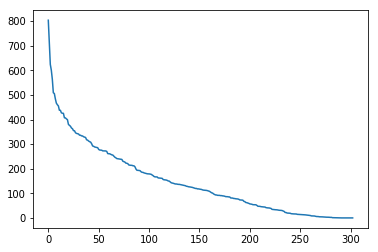

In [51]:
plt.plot(feat_imp.sort_values('importance', ascending=False).importance.values)

# 이상치 없는 데이터

## 데이터 로드

In [20]:
path = './data/'

In [21]:
train = pd.read_csv(path + 'train_v3.csv')
test = pd.read_csv(path + 'test_v3.csv')

In [22]:
train = train[train.outliers == 0]

## 제거할 피처

In [23]:
FEATS_EXCLUDED = ['first_active', 'card_id', 'target', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 
                  'new_purchase_date_max', 'new_purchase_date_min']

## Parameter

In [24]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

## training model

In [25]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=train.iloc[trn_idx]['target'])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=train.iloc[val_idx]['target'])
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(mean_squared_error(train.target.values, oof_lgb)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.60508	valid_1's rmse: 1.61676
[200]	training's rmse: 1.57258	valid_1's rmse: 1.58947
[300]	training's rmse: 1.5569	valid_1's rmse: 1.57843
[400]	training's rmse: 1.54652	valid_1's rmse: 1.57278
[500]	training's rmse: 1.53831	valid_1's rmse: 1.56901
[600]	training's rmse: 1.53133	valid_1's rmse: 1.56669
[700]	training's rmse: 1.52511	valid_1's rmse: 1.56515
[800]	training's rmse: 1.51955	valid_1's rmse: 1.56427
[900]	training's rmse: 1.51443	valid_1's rmse: 1.5636
[1000]	training's rmse: 1.50958	valid_1's rmse: 1.56307
[1100]	training's rmse: 1.50494	valid_1's rmse: 1.56258
[1200]	training's rmse: 1.50054	valid_1's rmse: 1.56232
[1300]	training's rmse: 1.49619	valid_1's rmse: 1.56206
[1400]	training's rmse: 1.492	valid_1's rmse: 1.5618
[1500]	training's rmse: 1.4879	valid_1's rmse: 1.56166
[1600]	training's rmse: 1.48388	valid_1's rmse: 1.56144
[1700]	training's rmse: 1.47992	valid_1's rmse:

In [27]:
model_without_outliers = pd.DataFrame({"card_id":test["card_id"].values})
model_without_outliers["target"] = predictions_lgb

# 이상치 예측 모델

## 데이터 로드

In [28]:
train = pd.read_csv(path + 'train_v3.csv')
test = pd.read_csv(path + 'test_v3.csv')

In [29]:
target = train['outliers']

## 제거할 피처

In [30]:
FEATS_EXCLUDED = ['first_active', 'card_id', 'target', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 
                  'new_purchase_date_max', 'new_purchase_date_min']

## 파라미터

In [31]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "rf",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 2333}

In [32]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print("CV score: {:<8.5f}".format(log_loss(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0439393	valid_1's binary_logloss: 0.0466941
[200]	training's binary_logloss: 0.0439582	valid_1's binary_logloss: 0.0466935
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.0439586	valid_1's binary_logloss: 0.0465615
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0439916	valid_1's binary_logloss: 0.0471326
[200]	training's binary_logloss: 0.044006	valid_1's binary_logloss: 0.0471322
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.0439602	valid_1's binary_logloss: 0.0470829
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0444197	valid_1's binary_logloss: 0.046345
[200]	training's binary_logloss: 0.0443985	valid_1's binary_logloss: 0.046319
[300]	training's binary_logloss: 0.0443899	valid_1's binary_logloss: 0.0462997
[400]	tra

In [43]:
clf.predict(test[train_columns])

array([0.10801868, 0.00260161, 0.00512331, ..., 0.00345008, 0.03046886,
       0.00325212])

In [33]:
outlier_prob = pd.DataFrame({"card_id":test["card_id"].values})
outlier_prob["target"] = predictions_lgb

# Combining

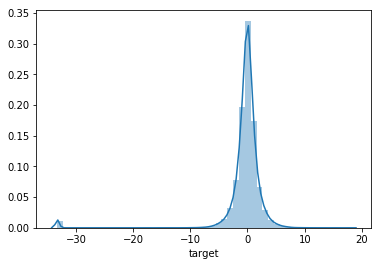

In [24]:
sns.distplot(train.target)

In [25]:
outlier_id = pd.DataFrame(outlier_prob.sort_values(by='target',ascending = False).head(50000)['card_id'])

In [26]:
best_submission = pd.read_csv(path + 'submission_best_score.csv')

In [27]:
most_likely_liers = best_submission.merge(outlier_id,how='right')

In [28]:
for card_id in most_likely_liers['card_id']:
    model_without_outliers.loc[model_without_outliers['card_id']==card_id,'target'] = most_likely_liers.loc[most_likely_liers['card_id']==card_id,'target'].values

In [29]:
model_without_outliers.to_csv("./data/combining_submission.csv", index=False)